In [2]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.8 MB 8.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install Prophet

In [4]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.metrics import r2_score


In [9]:
df = pd.read_csv("/content/despesa_ceaps_2017-2022.csv")

In [10]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2022,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,001/22,2022-03-01,Despesa com pagamento de aluguel de imóvel par...,6000.0,2173614


# Criando o Modelos

## ajeitando o dataset

Retirando colunas desnecessárias

In [11]:
df1=df.copy()

In [12]:
df1.head(2)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2022,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,001/22,2022-03-01,Despesa com pagamento de aluguel de imóvel par...,6000.0,2173614
1,2022,1,ACIR GURGACZ,Divulgação da atividade parlamentar,26.320.603/0001-64,INFORMANAHORA,000000000000310/A,2022-04-01,Despesa com divulgação da atividade parlamenta...,1500.0,2173615


In [13]:
df1[(df1["ANO"]==2022) & (df1["MES"] == 4) ].sort_values(by="DATA")

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
37,2022,4,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,004/22,2022-01-04,Despesa com pagamento de aluguel de imóvel par...,6000.00,2177655
2461,2022,4,OMAR AZIZ,"Contratação de consultorias, assessorias, pesq...",15.183.160/0001-90,UPLINK Assessoria e Consultoria Empresarial Ei...,544,2022-01-04,"Consultorias, assessorias, pesquisas, trabalho...",30000.00,2177489
2451,2022,4,NILDA GONDIM,"Aluguel de imóveis para escritório político, c...",041.876.994-06,LUCIELIO DANTAS DE MORAIS,abr2022,2022-01-04,Sem informacao,2000.00,2177762
2178,2022,4,MAILZA GOMES,"Aluguel de imóveis para escritório político, c...",339.222.762-53,LOURDES DE LIMA FERRAZ,Sem informacao,2022-01-04,Sem informacao,3000.00,2177555
730,2022,4,DÁRIO BERGER,"Contratação de consultorias, assessorias, pesq...",20.770.179/0001-73,FLB PUBLICIDADE E PROPAGANDA LTDA,2054,2022-01-04,Sem informacao,4650.00,2177459
...,...,...,...,...,...,...,...,...,...,...,...
559,2022,4,CID GOMES,"Locomoção, hospedagem, alimentação, combustíve...",18.977.100/0001-38,Jangada Comércio de Combustiveis LTDA,000005081,2022-06-04,Sem informacao,3784.31,2177843
3494,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,JBHH5Y,2022-06-04,"Companhia Aérea: AZUL, Localizador: JBHH5Y. Pa...",1663.61,2177879
2789,2022,4,RODRIGO CUNHA,"Aluguel de imóveis para escritório político, c...",410.696.501-10,DENISE GAMA WENZEL,Sem informacao,2022-06-04,DESPESA DE LOCAÇÃO DO ESCRITÓRIO DE APOIO DO S...,2500.00,2177935
3495,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,FRFFFI,2022-06-04,"Companhia Aérea: LATAM, Localizador: FRFFFI. P...",2324.00,2177912


Como só temos valores até o dia 12/04/2022, vamos dropar esse mes para não haver distroções

In [ ]:
meses = []
for mes in df1["MES"]:
  if mes < 10:
    meses.append("0"+str(mes))
  else:
    meses.append(mes)

meses.count(11)

df1["MES"] = meses

In [15]:
#criando a colune de referencia ANO_MES
df1["ANO_MES"] = df1["ANO"].astype(str)+"."+df1["MES"].astype(str)

In [77]:
df1["ANO_MES"][:10]

0    2022.01
1    2022.01
2    2022.01
3    2022.01
4    2022.01
5    2022.01
6    2022.02
7    2022.02
8    2022.02
9    2022.02
Name: ANO_MES, dtype: object

## Treino e teste

In [17]:
df_treino = df1[df["ANO"]<=2021].copy()
df_teste = df1[df["ANO"]>=2022].copy()

In [18]:
df_treino["ANO"].value_counts()

2017    26777
2018    24180
2019    21438
2021    16560
2020    13797
Name: ANO, dtype: int64

In [19]:
df_teste["ANO"].value_counts()

2022    3496
Name: ANO, dtype: int64

In [20]:
df_treino.drop(["SENADOR","TIPO_DESPESA","CNPJ_CPF","FORNECEDOR","DOCUMENTO","DETALHAMENTO","COD_DOCUMENTO","ANO","MES","DATA"],axis = 1, inplace = True)
df_teste.drop(["SENADOR","TIPO_DESPESA","CNPJ_CPF","FORNECEDOR","DOCUMENTO","DETALHAMENTO","COD_DOCUMENTO","ANO","MES","DATA"],axis = 1, inplace = True)

df_treino.sort_values(by="ANO_MES", inplace=True)
df_teste.sort_values(by="ANO_MES", inplace=True)

In [21]:
df_treino.head(2)

,VALOR_REEMBOLSADO,ANO_MES
88926,142.80,2017.01
82623,157.24,2017.01


In [22]:
df_treino.shape

(102752, 2)

In [23]:
df_teste.head(2)

,VALOR_REEMBOLSADO,ANO_MES
0,6000.00,2022.01
952,483.85,2022.01


In [24]:
df_teste = df_teste.groupby("ANO_MES").sum()
df_treino = df_treino.groupby("ANO_MES").sum()

In [25]:
df_treino.shape

(60, 1)

In [26]:
df_treino.head()

,VALOR_REEMBOLSADO
ANO_MES,
2017.01,1465428.27
2017.02,1938688.58
2017.03,2216613.75
2017.04,2258863.61
2017.05,2254378.95


In [27]:
#dropando o mes incompleto
df_teste.drop("2022.04",inplace = True)

In [28]:
df_teste

,VALOR_REEMBOLSADO
ANO_MES,
2022.01,1705516.10
2022.02,2089413.83
2022.03,1847779.53


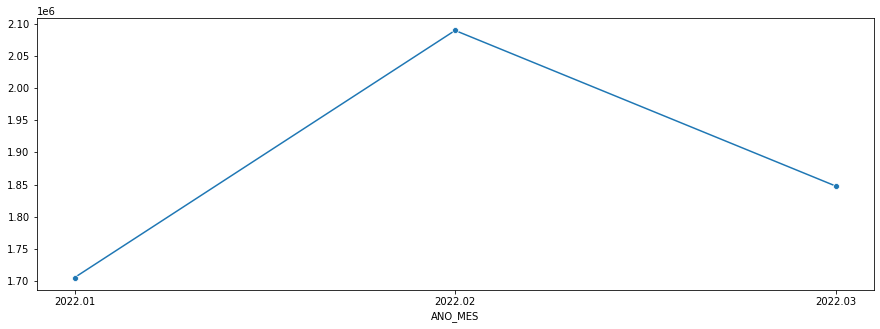

In [29]:
plt.figure(figsize = (15,5))
sns.lineplot(y=df_teste.values.reshape(1,-1).flatten() , x = df_teste.index, marker = "o")

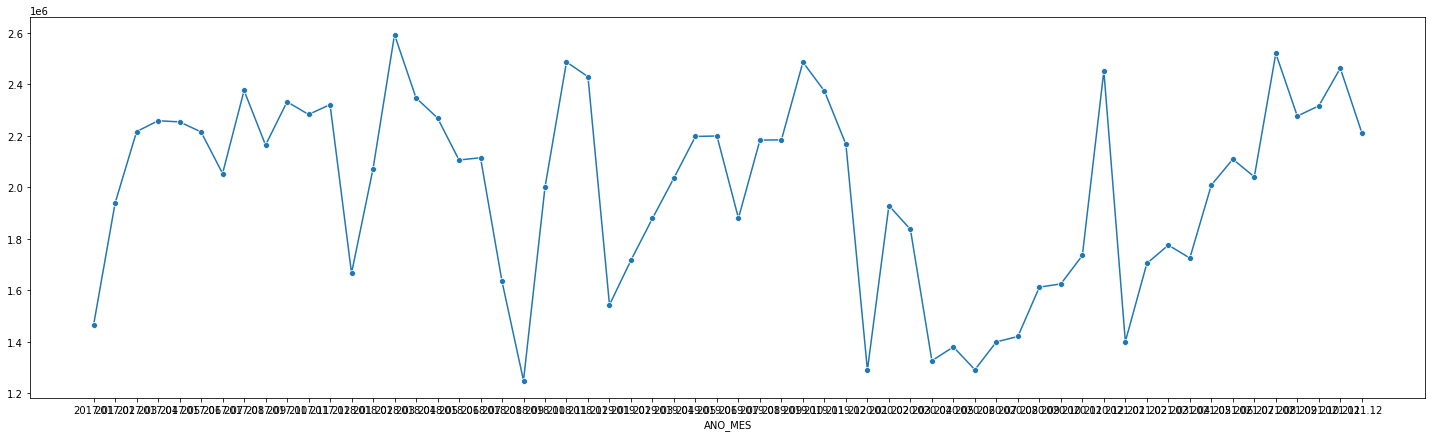

In [30]:
plt.figure(figsize = (25,7))
sns.lineplot(y=df_treino.values.reshape(1,-1).flatten() , x = df_treino.index,marker = "o")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


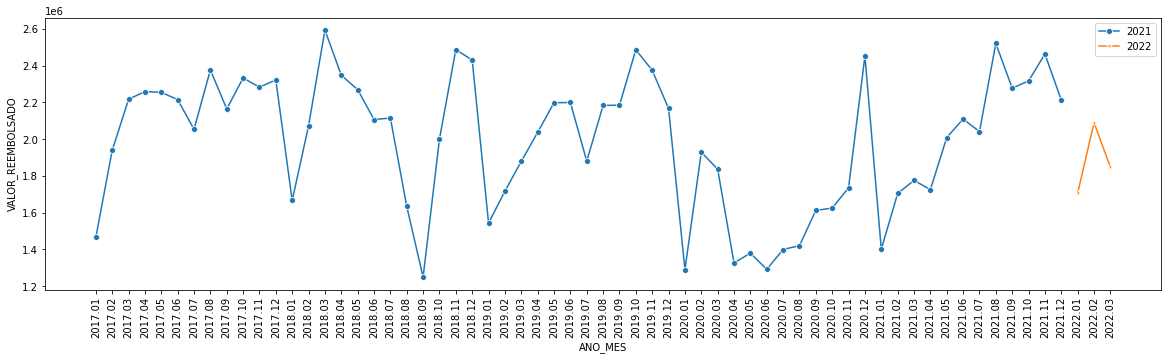

In [62]:
plt.figure(figsize = (20,5))
sns.lineplot(y=df_treino["VALOR_REEMBOLSADO"] , x = df_treino.index, label = "2021",marker = "o")
sns.lineplot(y=df_teste["VALOR_REEMBOLSADO"] , x = df_teste.index, label = "2022",marker = "*")
plt.xticks(rotation=90);

#Criar a Regressão Mensal

Com base nos dados de 2017 até 2021, vamos prever os valores gastos para o ano de 2022. Vamos comparar o modelo com o resultado encontrado nos 3 primeiros meses de 2022

## Regressão Linear Simples

In [109]:
dp = DeterministicProcess(
    index=df_treino.index, # datas do treino
    constant=True,         # y_intercept
    order=6,               # time dummy (trend)
    drop=True,             # drop termos se necessário, para evitar colinearidade
)

In [110]:
y = df_treino["VALOR_REEMBOLSADO"]
X = dp.in_sample()

In [111]:
X.head()

,const,trend,trend_squared,trend_cubed,trend**4,trend**5,trend**6
ANO_MES,,,,,,,
2017.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017.02,1.0,2.0,4.0,8.0,16.0,32.0,64.0
2017.03,1.0,3.0,9.0,27.0,81.0,243.0,729.0
2017.04,1.0,4.0,16.0,64.0,256.0,1024.0,4096.0
2017.05,1.0,5.0,25.0,125.0,625.0,3125.0,15625.0


In [112]:
model = LinearRegression(fit_intercept= False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [113]:
y_pred[:5]

ANO_MES
2017.01    1.537074e+06
2017.02    1.848924e+06
2017.03    2.067998e+06
2017.04    2.212369e+06
2017.05    2.297778e+06
dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


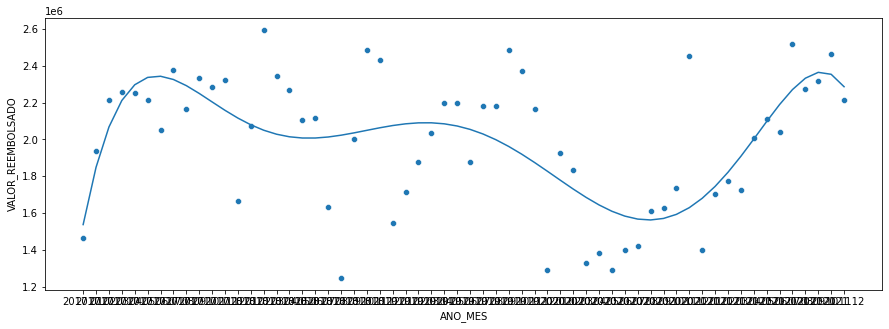

In [114]:
plt.figure(figsize=(15,5))
sns.scatterplot(y=df_treino.VALOR_REEMBOLSADO, x=df_treino.index)
sns.lineplot(y=y_pred, x=X.index)

In [115]:
X_fore = dp.out_of_sample(steps=3)
y_fore = pd.Series(model.predict(X_fore), index=df_teste.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

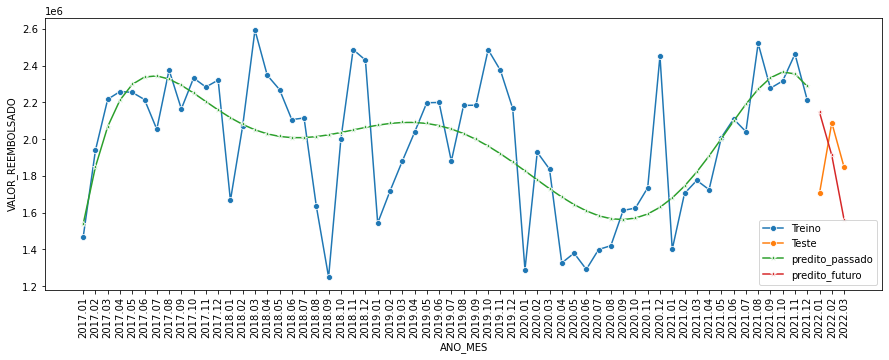

In [116]:
plt.figure(figsize=(15,5))
sns.lineplot(y=df_treino.VALOR_REEMBOLSADO, x=df_treino.index, label = "Treino", marker ="o")
sns.lineplot(y=df_teste.VALOR_REEMBOLSADO, x= df_teste.index, label = "Teste",marker ="o")
sns.lineplot(y=y_pred, x=X.index, label = "predito_passado",marker ="*",ci = True)
sns.lineplot(y=y_fore, x=y_fore.index, label = "predito_futuro", ci = True, marker ="*")

plt.xticks(rotation=90);

In [127]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true = df_treino["VALOR_REEMBOLSADO"].values,y_pred= y_pred)
print('MAE treino: %.2f' % mae)

MAE treino: 211126.55


In [126]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true = df_teste["VALOR_REEMBOLSADO"].values,y_pred= y_fore)
print('MAE teste: %.2f' % mae)

MAE teste: 301145.34


## Prophet

In [128]:
df_teste

,VALOR_REEMBOLSADO
ANO_MES,
2022.01,1705516.10
2022.02,2089413.83
2022.03,1847779.53


In [129]:
df_treinop = df_treino.copy()
df_treinop.reset_index(inplace=True)

In [130]:
datas = pd.date_range(start="2017",end="2022",freq="M")
datas

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
      

In [131]:
df_treinop["ds"] = datas
df_treinop["y"] = df_treinop["VALOR_REEMBOLSADO"]
df_treinop.drop(["ANO_MES","VALOR_REEMBOLSADO"], axis = 1,inplace = True )

In [132]:
prophet = Prophet()
prophet.fit(df_treinop)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [133]:
future = prophet.make_future_dataframe(periods=3,freq="M")
future.tail()

,ds
58,2021-11-30
59,2021-12-31
60,2022-01-31
61,2022-02-28
62,2022-03-31


In [134]:
forecast = prophet.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
58,2021-11-30,1.820752e+06,1.723787e+06,2.410693e+06,1.820752e+06,1.820752e+06,256221.728735,256221.728735,256221.728735,256221.728735,256221.728735,256221.728735,0.0,0.0,0.0,2.076974e+06
59,2021-12-31,1.815031e+06,1.855449e+06,2.550357e+06,1.815031e+06,1.815031e+06,399258.198312,399258.198312,399258.198312,399258.198312,399258.198312,399258.198312,0.0,0.0,0.0,2.214289e+06
60,2022-01-31,1.809310e+06,9.141770e+05,1.619587e+06,1.809308e+06,1.809310e+06,-538905.787244,-538905.787244,-538905.787244,-538905.787244,-538905.787244,-538905.787244,0.0,0.0,0.0,1.270404e+06
61,2022-02-28,1.804142e+06,1.265413e+06,1.952513e+06,1.804136e+06,1.804147e+06,-185906.279004,-185906.279004,-185906.279004,-185906.279004,-185906.279004,-185906.279004,0.0,0.0,0.0,1.618236e+06
62,2022-03-31,1.798421e+06,1.480321e+06,2.222108e+06,1.798407e+06,1.798432e+06,44227.777731,44227.777731,44227.777731,44227.777731,44227.777731,44227.777731,0.0,0.0,0.0,1.842648e+06


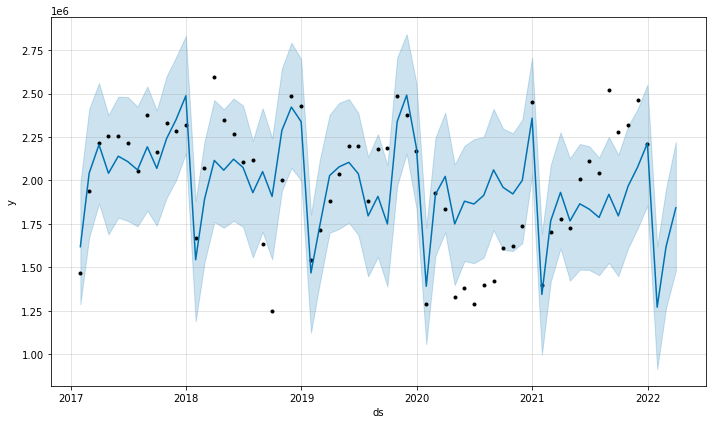

In [135]:
fig1= prophet.plot(forecast)

In [136]:
df_teste.VALOR_REEMBOLSADO

ANO_MES
2022.01    1705516.10
2022.02    2089413.83
2022.03    1847779.53
Name: VALOR_REEMBOLSADO, dtype: float64

In [137]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [138]:
y_treino = df_treino.VALOR_REEMBOLSADO
y_teste = df_teste.VALOR_REEMBOLSADO

X_treino_pred = forecast[["yhat","yhat_lower","yhat_upper"]][:-3]
X_teste_pred = forecast[["yhat","yhat_lower","yhat_upper"]][-3:]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

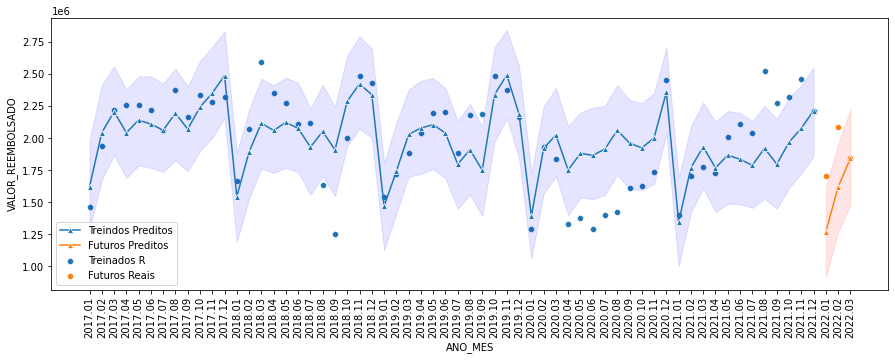

In [139]:
plt.figure(figsize=(15,5))

#plotando os dados reais como scatter
sns.scatterplot(y=df_treino.VALOR_REEMBOLSADO, x=df_treino.index, label = "Treinados R", marker ="o") #y_treino
sns.scatterplot(y=df_teste.VALOR_REEMBOLSADO, x= df_teste.index, label = "Futuros Reais",marker ="o") #y_teste

#plotando valores preditos para o treino + ci do modelo
sns.lineplot(y=X_treino_pred["yhat"], x=df_treino.index, label = "Treindos Preditos",marker ="^")
plt.fill_between(X_treino_pred.index, X_treino_pred["yhat_lower"], X_treino_pred["yhat_upper"].values , color='b', alpha=.1)

#plotando valores preditos para o teste + ci do modelo
sns.lineplot(y=X_teste_pred["yhat"], x=df_teste.index, label = "Futuros Preditos", ci = 0.95, marker ="^")
plt.fill_between(X_teste_pred.index, X_teste_pred["yhat_lower"], X_teste_pred["yhat_upper"], color='r', alpha=.1)
plt.legend(loc='lower left')

plt.xticks(rotation=90);

In [148]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true = df_treino["VALOR_REEMBOLSADO"].values,y_pred= X_treino_pred["yhat"])
print('MAE teste: %.2f' % mae)

MAE teste: 210948.22


In [149]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true = df_teste["VALOR_REEMBOLSADO"].values,y_pred= X_teste_pred["yhat"])
print('MAE teste: %.2f' % mae)

MAE teste: 303807.19


In [142]:
inrange = 0
outofrange  = 0
for valorPmin, valorT, valorPmax in zip( X_treino_pred["yhat_lower"],df_treino.VALOR_REEMBOLSADO, X_treino_pred["yhat_upper"]):
  if (valorPmin <= valorT) and (valorT <= valorPmax):
    inrange +=1
  else:
    outofrange +=1

print(f" O modelo acertou {inrange / (inrange+outofrange)*100}% dos dados dentro do intervalo de confiança para durante o TREINO")

 O modelo acertou 78.33333333333333% dos dados dentro do intervalo de confiança para durante o TREINO


In [143]:
inrange = 0
outofrange  = 0
for valorPmin, valorT, valorPmax in zip( X-X_teste_pred["yhat_lower"],df_teste.VALOR_REEMBOLSADO, X_teste_pred["yhat_upper"]):
  if (valorPmin <= valorT) and (valorT <= valorPmax):
    inrange +=1
  else:
    outofrange +=1

print(f" O modelo acertou {inrange / (inrange+outofrange)*100}% dos dados dentro do intervalo de confiança para durante o TESTE")

 O modelo acertou 33.33333333333333% dos dados dentro do intervalo de confiança para durante o TESTE


O modelo de testes acertou bastante.
O modelo de treino errou 2 de 3 amostras.
Ocorre que na 3ª ele praticamente cravou o resultado como valor predito, e os erros ficaram pouco acima do range.

Por algum motivo o começo de 2022 teve Grandes gastos no começo do ano. Quando normalmente este primeiro mes é de poucos gastos, como visto no EDA.
Talvez por ser ano eleitoral?

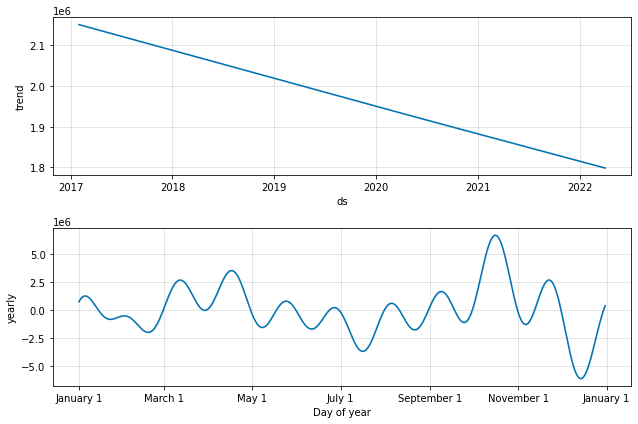

In [144]:
fig2 = prophet.plot_components(forecast)